In [15]:
!pip install ppscore
!pip install seaborn

# Ипортируем нужные библиотеки

In [219]:
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
import ppscore
import seaborn as sbs
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import  keras
from sklearn.model_selection import  train_test_split

In [2]:
data = pd.read_csv('drive/MyDrive/NN_CW/Tutorial/data.csv')

# Анализируем данные

In [4]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,511.000000,511.000000,511.000000,511.000000,511.000000,506.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,3.584139,11.252446,11.151096,0.068493,0.554757,6.287589,68.616243,3.783876,9.485323,407.440313,18.500000,356.600900,12.879550,22.682192
std,8.564433,23.234838,6.828175,0.252838,0.115310,0.703802,28.099130,2.098631,8.688469,167.903532,2.200348,90.882679,7.797416,9.484262
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082325,0.000000,5.190000,0.000000,0.449000,5.885500,45.050000,2.100350,4.000000,279.500000,17.400000,374.710000,7.065000,17.050000
50%,0.261690,0.000000,9.690000,0.000000,0.538000,6.209000,77.300000,3.152300,5.000000,330.000000,19.100000,391.340000,11.450000,21.200000
75%,3.621175,12.500000,18.100000,0.000000,0.624000,6.629750,94.050000,5.118000,24.000000,666.000000,20.200000,396.210000,17.105000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,23.000000,396.900000,76.000000,67.000000


In [6]:
data.shape

(511, 14)

In [8]:
data[data.isna().any(axis=1)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
10,0.22489,12.5,7.87,0,0.524,NaN,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
35,0.06417,0.0,5.96,0,0.499,NaN,68.2,3.3603,5,279,19.2,396.90,9.68,18.9
63,0.12650,25.0,5.13,0,0.453,NaN,43.4,7.9809,8,284,19.7,395.58,9.50,25.0
96,0.11504,0.0,2.89,0,0.445,NaN,69.6,3.4952,2,276,18.0,391.83,11.34,21.4
135,0.55778,0.0,21.89,0,0.624,NaN,98.2,2.1107,4,437,21.2,394.67,16.96,18.1


Всего 5 строк с пропущенными данными, поэтому лучше всего удалить данные строки

In [9]:
data = data[~data.isna().any(axis=1)]

Воспользуемся библиотекой ppscore, чтобы оценить потонциальную предективную способность каждой фичи

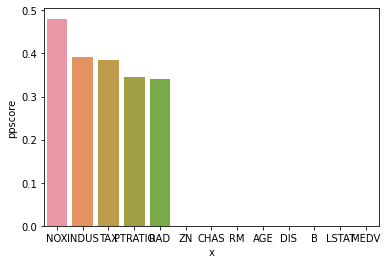

In [17]:
predictors_df = ppscore.predictors(data, 'CRIM')
sbs.barplot(data=predictors_df, x="x", y="ppscore")

In [29]:
FEATURE_COLUMNS  = ['NOX', 'INDUS', 'TAX', 'PTRATIO', 'RAD']
TARGET_COLUMN = 'CRIM'

# Создадим многослойный перцептрон

In [210]:
model = keras.Sequential([
  keras.layers.Dense(16, activation='relu', input_shape=(13,), kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
])

In [211]:
model.count_params()

496

In [212]:
model.compile(
    loss=tf.losses.mse,
     metrics=[tf.metrics.mean_absolute_percentage_error],
     optimizer=tf.optimizers.RMSprop(learning_rate=10e-5))

# Обучим созданную модель

Выберем наиболее перспективные фичи и разделим данные на тестовую и обучающую выборки

In [213]:
y = data[TARGET_COLUMN]
x = data.drop(TARGET_COLUMN, axis=1)#

Нормализуем данные для лучшей сходимости сети

In [214]:
x = scale(x)

In [215]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2)

In [216]:
history = model.fit(train_x, train_y, epochs=3000, validation_data=(test_x, test_y), batch_size=16)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 501/3000
26/26 [==============================] - 0s 3ms/step - loss: 32.4422 - mean_absolute_percentage_error: 152.6431 - val_loss: 24.7922 - val_mean_absolute_percentage_error: 101.6877
Epoch 502/3000
26/26 [==============================] - 0s 4ms/step - loss: 62.4411 - mean_absolute_percentage_error: 161.3236 - val_loss: 24.8053 - val_mean_absolute_percentage_error: 101.6397
Epoch 503/3000
26/26 [==============================] - 0s 4ms/step - loss: 45.7993 - mean_absolute_percentage_error: 182.9273 - val_loss: 24.8095 - val_mean_absolute_percentage_error: 101.6170
Epoch 504/3000
26/26 [==============================] - 0s 3ms/step - loss: 90.7210 - mean_absolute_percentage_error: 150.9159 - val_loss: 24.8021 - val_mean_absolute_percentage_error: 101.5102
Epoch 505/3000
26/26 [==============================] - 0s 3ms/step - loss: 18.3734 - mean_absolute_percentage_error: 157.8742 - val_loss: 24.8151 - val_mea

Приведем графики MSE и MAPE в зависимости от эпохи

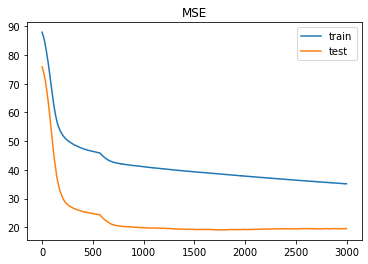

In [217]:
plt.title('MSE')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'])

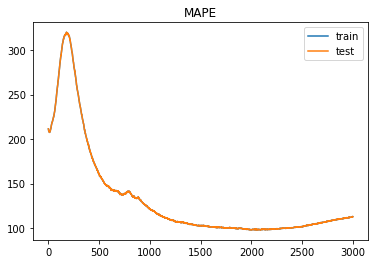

In [218]:
plt.title('MAPE')
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['mean_absolute_percentage_error'])
plt.legend(['train', 'test'])

По графикам видно, что модель может быть дообучена

In [220]:
model2 = Ridge()
model2.fit(train_x, train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [221]:
tf.metrics.mean_squared_error(test_y, model2.predict(test_x))

<tf.Tensor: shape=(), dtype=float64, numpy=24.939215997136998>

В сравнении с простой моделью (линенйой регрессией с регуляризацией) использование нейросети дает уменьшение функции потерь на 5 единиц